<a href="https://colab.research.google.com/github/Kostratana/diplome_computer_vision_airport/blob/main/Yolo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests, re, json, os, sys, shutil, random
from tqdm import tqdm

images_scans_url = 'https://cloud.mail.ru/public/1htD/QZ5mdyvyc/Dataset_razmet'
images_aero_url = 'https://cloud.mail.ru/public/1htD/QZ5mdyvyc/Dataset_%20airport'
labels_scans_url = 'https://cloud.mail.ru/public/1htD/QZ5mdyvyc/Dataset_razm_label'
labels_aero_url = 'https://cloud.mail.ru/public/1htD/QZ5mdyvyc/Dataset_airport_labels'

# каталог со всеми изображениями
ALL_IMAGES_PATH = '/content/dataset_all/images'

# каталог со всеми аннотациями
ALL_LABELS_PATH = '/content/dataset_all/labels'

# корневой каталог подготовленного датасета
PREPAIRED_DATASET_PATH = '/content/dataset'

# временный каталог для обработки загружаемых файлов
TEMP_DIR = '/content/temp'

# вариант деления на выборки.
# 1 - деление полного набора случайным образом в заданных пропорциях
# 2 - деление полного набора в заданных пропорциях, с учетом "родства" изображений
# пропорции задаются в ячейках с вариантами
SPLIT_VARIANT = 2

def sizeof_fmt(num: int | float) -> str:
    for x in ['bytes', 'KB', 'MB', 'GB']:
        if num < 1024.0:
            return "%.1f %s" % (num, x)

        num /= 1024.0

    return "%.1f %s" % (num, 'TB')

def get_cloudmail_data(url):
    res = requests.get(url)
    files_list = json.loads(re.search(r'"list":(\[{.*?}\]),"owner"', res.text)[1])
    cloud_url = json.loads(re.search(r'"weblink_get":({.*?}),', res.text)[1])['url']
    return {'cloud_url': cloud_url, 'files_list': files_list}

def get_cloudmail_file(cloud_url, file_data):
    f_url = f'{cloud_url}/{file_data["weblink"]}'
    f_name = file_data['name']
    res_d = requests.get(f_url, stream=True)
    f_size = int(res_d.headers.get('content-length', 0))
    print(f'{f_name}:', sizeof_fmt(f_size), '---> ', end='')
    chunk_size = 1024 * 1024
    num_bars = int(f_size / chunk_size)
    new_filename = os.path.join(TEMP_DIR, f_name)
    with open(new_filename, 'wb') as fp:
        for data in tqdm(res_d.iter_content(chunk_size), total=num_bars, unit='MB'):
            fp.write(data)
    return new_filename

def unpack_and_move(zipfile, extension, target_dir):
    !unzip -q '{zipfile}' -d {TEMP_DIR}
    tree = os.walk(TEMP_DIR)
    reg_obj = re.compile(r'\d{5}_\d\.' + extension)
    cnt = 0
    for path, _, files in tree:
        for filename in files:
            if re.fullmatch(reg_obj, filename):
                fullname = os.path.join(path, filename)
                shutil.move(fullname, os.path.join(target_dir, filename))
                cnt += 1
    return cnt

def label_is_correct(filename):
    with open(filename, 'r') as fp:
        for line in fp:
            if not line[:2] == '0 ':
                return False
    return True

def check_labels(label_list):
    all_correct = True
    for filename in all_labels_list:
        if not label_is_correct(os.path.join(ALL_LABELS_PATH, filename)):
            print('Некорректная метка:', os.path.join(ALL_LABELS_PATH, filename))
            all_correct = False
    if all_correct:
        print('Все метки корректны')
    return all_correct

In [ ]:
!rm -rf /content/sample_data
for path in [TEMP_DIR, ALL_IMAGES_PATH, ALL_LABELS_PATH, PREPAIRED_DATASET_PATH]:
    os.makedirs(path, exist_ok=True)   #  данный код сначала удаляет директорию `/content/sample_data`, а затем создает директории по путям, указанным в списке `[TEMP_DIR, ALL_IMAGES_PATH, ALL_LABELS_PATH, PREPAIRED_DATASET_PATH]`

In [ ]:
# скачивание подготовленных архивов с разметкой
for url in [labels_scans_url, labels_aero_url]:
    cm_data = get_cloudmail_data(url)
    for file_data in cm_data['files_list']:
        filename = get_cloudmail_file(cm_data['cloud_url'], file_data)
        labels_count = unpack_and_move(filename, 'txt', ALL_LABELS_PATH)
        if labels_count:
            print('\033[32m', end='')
        else:
            print('\033[31m', end='')
        print(f'Найдено {labels_count} меток\033[0m')
        !rm -rf {TEMP_DIR}/*

all_labels_list = sorted(os.listdir(ALL_LABELS_PATH))

print()
all_correct = check_labels(all_labels_list)

# цифры из скрипта обработки изображений, для выделения номеров архивов
# в scans "чистых" 302 файла, "нечистых" 1335
# берем индексы для чистых 1-400, для нечистых 401-1800
# для аэропорта в дальнейшем с 1801
# аэропорт 11-12 - 2137 файлов. 1801-4000
img_scans_zip = sorted({f'{(x % 19 + 1):02}.zip' for i in all_labels_list if (x := int(i[:5])) in range(401, 1801)} | {'annotated.zip'})
img_aero_zip = sorted({f'{(x % 19 + 1):02}.zip' for i in all_labels_list if (x := int(i[:5])) in range(1801, 4001)})

print()
print('Всего', len(all_labels_list), 'меток')
print('Требуемые файлы архивов из scans:', img_scans_zip)
print('Требуемые файлы архивов из aero:', img_aero_zip)

(10) Scans.zip: 47.1 KB ---> 

1MB [00:00,  6.63MB/s]


Найдено 210 меток
01.zip: 56.0 KB ---> 

1MB [00:00,  4.89MB/s]


Найдено 210 меток
03 (1).zip: 43.3 KB ---> 

1MB [00:00,  5.33MB/s]


Найдено 213 меток
04_scans.zip: 44.1 KB ---> 

1MB [00:00,  6.76MB/s]


Найдено 213 меток
06_labels.zip: 46.6 KB ---> 

1MB [00:00,  5.32MB/s]


Найдено 213 меток
07.zip: 70.5 KB ---> 

1MB [00:00,  4.42MB/s]


Найдено 213 меток
08_scans.zip: 65.7 KB ---> 

1MB [00:00,  4.01MB/s]


Найдено 210 меток
09_labels_scans.zip: 40.7 KB ---> 

1MB [00:00,  7.46MB/s]


Найдено 210 меток
11.zip: 38.1 KB ---> 

1MB [00:00,  5.97MB/s]


Найдено 210 меток
12_labels.zip: 37.6 KB ---> 

1MB [00:00,  6.20MB/s]


Найдено 210 меток
15_scans.zip: 40.1 KB ---> 

1MB [00:00,  5.56MB/s]


Найдено 210 меток
17 scan.zip: 42.4 KB ---> 

1MB [00:00,  5.59MB/s]


Найдено 210 меток
18 (Labels).zip: 30.8 KB ---> 

1MB [00:00,  6.92MB/s]


Найдено 210 меток
Scan 05.zip: 48.4 KB ---> 

1MB [00:00,  5.07MB/s]


Найдено 213 меток
annotated.zip: 136.4 KB ---> 

1MB [00:00,  2.79MB/s]


Найдено 906 меток
razmetka_13.zip: 43.4 KB ---> 

1MB [00:00,  5.29MB/s]


Найдено 210 меток
разметка_сканс_14.zip: 53.9 KB ---> 

1MB [00:00,  5.64MB/s]


Найдено 210 меток
03_airport.zip: 87.4 KB ---> 

1MB [00:00,  3.97MB/s]


Найдено 336 меток
04_aero.zip: 89.1 KB ---> 

1MB [00:00,  4.04MB/s]


Найдено 336 меток
06_aero_labels.zip: 96.2 KB ---> 

1MB [00:00,  3.14MB/s]


Найдено 336 меток
07_airport.zip: 89.8 KB ---> 

1MB [00:00,  3.02MB/s]


Найдено 336 меток
09_Airport.zip: 78.1 KB ---> 

1MB [00:00,  4.11MB/s]


Найдено 336 меток
11_airport.zip: 81.0 KB ---> 

1MB [00:00,  4.04MB/s]


Найдено 336 меток
13_airport (1).zip: 86.0 MB ---> 

86MB [00:08, 10.34MB/s]


Найдено 0 меток
14_разметка аэропорт-2023_09_13_20_53_35-yolo 1.1.zip: 86.8 KB ---> 

1MB [00:00,  4.07MB/s]


Найдено 336 меток
17_airport.zip: 86.7 KB ---> 

1MB [00:00,  4.08MB/s]


Найдено 336 меток
18 Aeroport (Labels).zip: 76.0 KB ---> 

1MB [00:00,  4.04MB/s]


Найдено 336 меток
Aeroport 05.zip: 81.5 KB ---> 

1MB [00:00,  4.10MB/s]


Найдено 336 меток
airport_08.zip: 175.8 KB ---> 

1MB [00:00,  2.67MB/s]


Найдено 336 меток
airport_10.zip: 84.8 KB ---> 

1MB [00:00,  4.07MB/s]


Найдено 336 меток
airport_15.zip: 74.6 KB ---> 

1MB [00:00,  4.09MB/s]


Найдено 333 меток

Все метки корректны

Всего 8646 меток
Требуемые файлы архивов из scans: ['01.zip', '03.zip', '04.zip', '05.zip', '06.zip', '07.zip', '08.zip', '09.zip', '10.zip', '11.zip', '12.zip', '13.zip', '14.zip', '15.zip', '17.zip', '18.zip', 'annotated.zip']
Требуемые файлы архивов из aero: ['03.zip', '04.zip', '05.zip', '06.zip', '07.zip', '08.zip', '09.zip', '10.zip', '11.zip', '14.zip', '15.zip', '17.zip', '18.zip']


In [ ]:
# скачивание только архивов с изображениями, соответствующими данным разметки,
# чтобы не скачивать все архивы
!rm -rf {ALL_IMAGES_PATH}/*
!rm -rf {TEMP_DIR}/*

for imgs_url, imgs_zip in zip([images_scans_url, images_aero_url], [img_scans_zip, img_aero_zip]):
    print(imgs_url)
    cm_data = get_cloudmail_data(imgs_url)
    files_list = [file_data for file_data in cm_data['files_list'] if file_data['name'] in imgs_zip]
    for file_data in files_list:
        filename = get_cloudmail_file(cm_data['cloud_url'], file_data)
        images_count = unpack_and_move(filename, 'tiff', ALL_IMAGES_PATH)
        print(f'Найдено {images_count} изображений')
        !rm -rf {TEMP_DIR}/*

all_images_list = sorted(os.listdir(ALL_IMAGES_PATH))
print('Всего', len(all_images_list), 'изображений')

https://cloud.mail.ru/public/1htD/QZ5mdyvyc/Dataset_razmet
01.zip: 51.6 MB ---> 

 86%|████████▋ | 44/51 [01:27<00:13,  1.96s/MB]

In [ ]:
# сравнение списков изображений и меток
correct = [i.rsplit('.', 1)[0] for i in sorted(all_labels_list)] == [i.rsplit('.', 1)[0] for i in sorted(all_images_list)]
print(['Наборы файлов НЕ соответствуют!!!' ,'Наборы файлов соответствуют'][correct])

In [ ]:
if SPLIT_VARIANT == 1:
    # подготовка train, val, test выборок
    # деление полного набора данных в пропорциях
    import random

    !rm -rf {PREPAIRED_DATASET_PATH}/*

    filename_wo_ext = [i.rsplit('.', 1)[0] for i in all_labels_list]
    random.shuffle(filename_wo_ext)
    all_qty = len(filename_wo_ext)

    # доля изображений для валидации и теста. остальное пойдет в тренировочный набор
    # если указать 0 - соответствующая выборка не создается
    VAL_SIZE = 0.2
    TEST_SIZE = 0.1

    test_edge = int(all_qty * TEST_SIZE)
    val_edge = test_edge + int(all_qty * VAL_SIZE)

    test_qty = 0
    val_qty = 0

    if TEST_SIZE:
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'test', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'test', 'labels')
        os.makedirs(dst_labels_path)
        for filename in filename_wo_ext[:test_edge]:
            shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
            shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        test_qty = len(os.listdir(dst_images_path))

    if VAL_SIZE:
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'val', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'val', 'labels')
        os.makedirs(dst_labels_path)
        for filename in filename_wo_ext[test_edge:val_edge]:
            shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
            shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        val_qty = len(os.listdir(dst_images_path))

    if True: #for train
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'train', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'train', 'labels')
        os.makedirs(dst_labels_path)
        for filename in filename_wo_ext[val_edge:]:
            shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
            shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        train_qty = len(os.listdir(dst_images_path))

    print('Размер тренировочной выборки:', train_qty)
    print('Размер проверочной выборки:', val_qty)
    print('Размер тестовой выборки:', test_qty)

In [ ]:
if SPLIT_VARIANT == 2:
    # подготовка train, val, test выборок
    # деление набора данных с учетом того, что каждая тройка файлов производная от одного
    import random

    !rm -rf {PREPAIRED_DATASET_PATH}/*

    filenumbers = sorted({i[:5] for i in all_labels_list})
    random.shuffle(filenumbers)
    all_qty = len(filenumbers)

    # доля изображений для валидации и теста. остальное пойдет в тренировочный набор
    # если указать 0 - соответствующая выборка не создается
    VAL_SIZE = 0.2
    TEST_SIZE = 0.1

    test_edge = int(all_qty * TEST_SIZE)
    val_edge = test_edge + int(all_qty * VAL_SIZE)

    test_qty = 0
    val_qty = 0

    if TEST_SIZE:
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'test', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'test', 'labels')
        os.makedirs(dst_labels_path)
        for filenumber in filenumbers[:test_edge]:
            for i in range(1, 4):
                filename = f'{filenumber}_{i}'
                shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
                shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        test_qty = len(os.listdir(dst_images_path))

    if VAL_SIZE:
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'val', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'val', 'labels')
        os.makedirs(dst_labels_path)
        for filenumber in filenumbers[test_edge:val_edge]:
            for i in range(1, 4):
                filename = f'{filenumber}_{i}'
                shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
                shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        val_qty = len(os.listdir(dst_images_path))

    if True: #for train
        src_images_path = ALL_IMAGES_PATH
        src_labels_path = ALL_LABELS_PATH
        dst_images_path = os.path.join(PREPAIRED_DATASET_PATH, 'train', 'images')
        os.makedirs(dst_images_path)
        dst_labels_path = os.path.join(PREPAIRED_DATASET_PATH, 'train', 'labels')
        os.makedirs(dst_labels_path)
        for filenumber in filenumbers[val_edge:]:
            for i in range(1, 4):
                filename = f'{filenumber}_{i}'
                shutil.copy(os.path.join(src_images_path, f'{filename}.tiff'), os.path.join(dst_images_path, f'{filename}.tiff'))
                shutil.copy(os.path.join(src_labels_path, f'{filename}.txt'), os.path.join(dst_labels_path, f'{filename}.txt'))
        train_qty = len(os.listdir(dst_images_path))

    print('Размер тренировочной выборки:', train_qty)
    print('Размер проверочной выборки:', val_qty)
    print('Размер тестовой выборки:', test_qty)

In [ ]:
# дополнительный тестовый набор с только из изображений с запрещенкой
os.makedirs('/content/dataset/test_2', exist_ok=True)
!rm -rf /content/dataset/test_2/*
os.makedirs('/content/dataset/test_2/images')
os.makedirs('/content/dataset/test_2/labels')

for label in os.listdir('/content/dataset/test/labels'):
    label_fname = os.path.join('/content/dataset/test/labels', label)
    with open(label_fname) as fp:
        if len(fp.readlines()):
            image_fname = label_fname.replace('.txt', '.tiff').replace('labels', 'images')
            shutil.copy(label_fname, label_fname.replace('test', 'test_2'))
            shutil.copy(image_fname, image_fname.replace('test', 'test_2'))

print('Изображений:', len(os.listdir('/content/dataset/test_2/images')))
print('меток:', len(os.listdir('/content/dataset/test_2/labels')))

In [ ]:
YAML_FILE = '/content/dataset/sibscan.yaml'
with open(YAML_FILE, 'w') as fp:
    yaml_text = """
    path: /content/dataset
    train: train/images
    val: val/images
    test: test/images


    # Classes
    names:
        0: danger
    """
    fp.write(yaml_text)

In [ ]:
%cat /content/dataset/sibscan.yaml

In [ ]:
YAML_FILE = '/content/dataset/val.yalm'
with open(YAML_FILE, 'w') as fp:
    yaml_text = """
    path: /content/dataset
    train: train/images
    train: train/images
    val: val/images



    # Classes
    names:
        0: danger
    """
    fp.write(yaml_text)

In [ ]:
%cat /content/dataset/val.yalm

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
from ultralytics import YOLO

# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')

# Обучение модели
results = model.train(data='/content/dataset/val ', imgsz=640, epochs=20, batch=16, name='yolov8n_custom2')
# Сохранение результатов обучения
model.save('path_to_save_model.pt')

In [ ]:
!zip -r /content/runs.zip /content/runs

In [ ]:
!wget https://example.com/runs.zip

In [ ]:
from ultralytics import YOLO

# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')

# Обучение модели
results = model.train(data='/content/dataset/sibscan.yaml', imgsz=640, epochs=20, batch=32, name='yolov8n_custom')
# Сохранение результатов обучения
model.save('path_to_save_model_val.pt')

In [ ]:
import locale  #  способ управления локальными настройками в Python

In [ ]:
locale.getpreferredencoding()  # поддерживает множество символов Unicode.


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8" # устанавливает предпочтительную кодировку на "UTF-8

In [ ]:
!zip -r /content/runs.zip /content/runs   # после выполнения этой команды, в папке "/content" появится архив "runs.zip", содержащий все файлы и папки из папки "/content/runs".

In [ ]:
!cp -r /content/runs /content/drive/My\ Drive/  #Этот код используется для копирования папки "runs" в папку "My Drive"

In [ ]:
# Для отображения содержимого папки "runs"
import os

# Просмотр содержимого папки "runs"
for root, dirs, files in os.walk('runs'):
    for file in files:
        print(os.path.join(root, file))


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Пути к пяти изображениям в директории
image_paths = ['/content/результаты_обучения/F1_curve.png', '/content/результаты_обучения/PR_curve.png', '/content/результаты_обучения/P_curve.png', '/content/результаты_обучения/R_curve.png', '/content/результаты_обучения/confusion_matrix.png']

# Создание subplot с одним рядом и пятью колонками
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Загрузка и отображение каждого изображения в subplot
for i in range(5):
    img = mpimg.imread(image_paths[i])
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Пути к трех изображений в директории
image_paths = ['/content/sample_data/runs_best /labels_correlogram.jpg', '/content/sample_data/runs_best /labels.jpg','/content/sample_data/runs_best /confusion_matrix_normalized.png']

# Создание subplot с одним рядом и двумя колонками
fig, axs = plt.subplots(1, 3, figsize=(30, 6))

# Загрузка и отображение каждого изображения в subplot
for i in range(3):
    if i < len(image_paths):
        img = mpimg.imread(image_paths[i])
        axs[i].imshow(img)
        axs[i].axis('off')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = ['/content/sample_data/runs_best /results.png']

fig, axs = plt.subplots(1, 1, figsize=(30, 6))



for i in range(1):
    if i < len(image_paths):
        img = mpimg.imread(image_paths[i])
        axs.imshow(img)
        axs.axis('off')

plt.show()





Визуализация train_batch

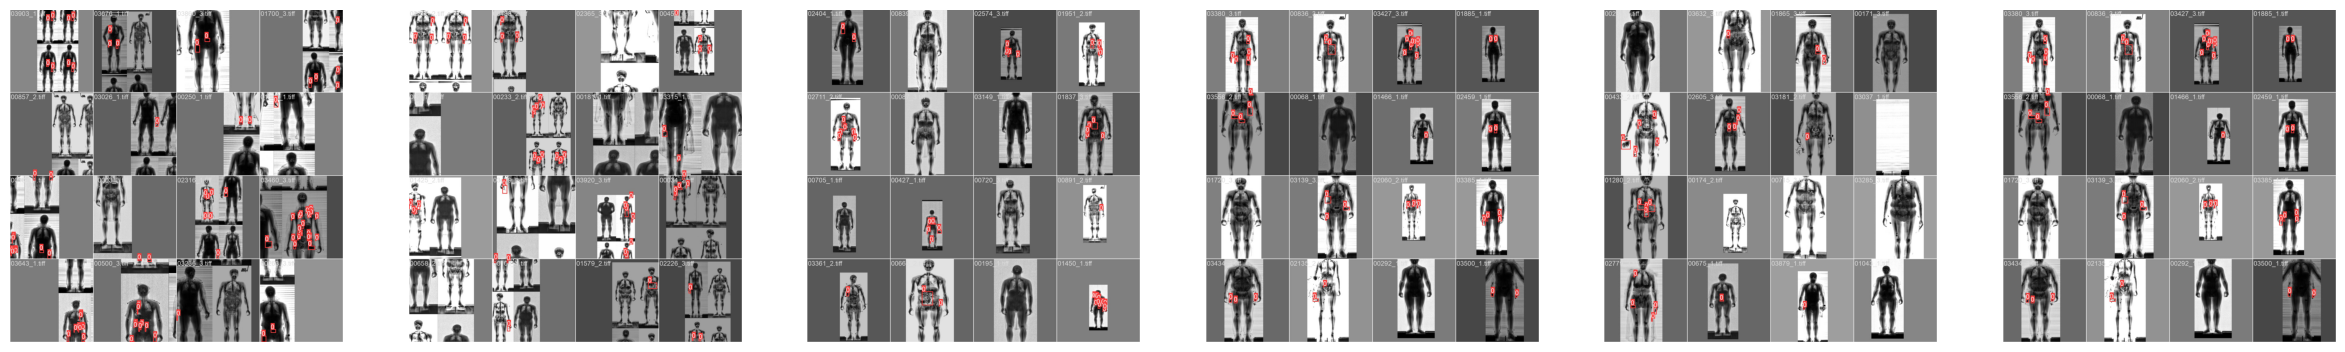

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 6 изображений
image_paths = ['/content/sample_data/runs_best /train_batch0.jpg','/content/sample_data/runs_best /train_batch1.jpg','/content/sample_data/runs_best /train_batch7600.jpg','/content/sample_data/runs_best /train_batch7602.jpg','/content/sample_data/runs_best /train_batch7601.jpg','/content/sample_data/runs_best /train_batch7602.jpg']
# Создание subplot с одним рядом и двумя колонками
fig, axs = plt.subplots(1, 6, figsize=(30, 6))

# Загрузка и отображение каждого изображения в subplot
for i in range(6):
    if i < len(image_paths):
        img = mpimg.imread(image_paths[i])
        axs[i].imshow(img)
        axs[i].axis('off')

plt.show()

Визуализация val_batch

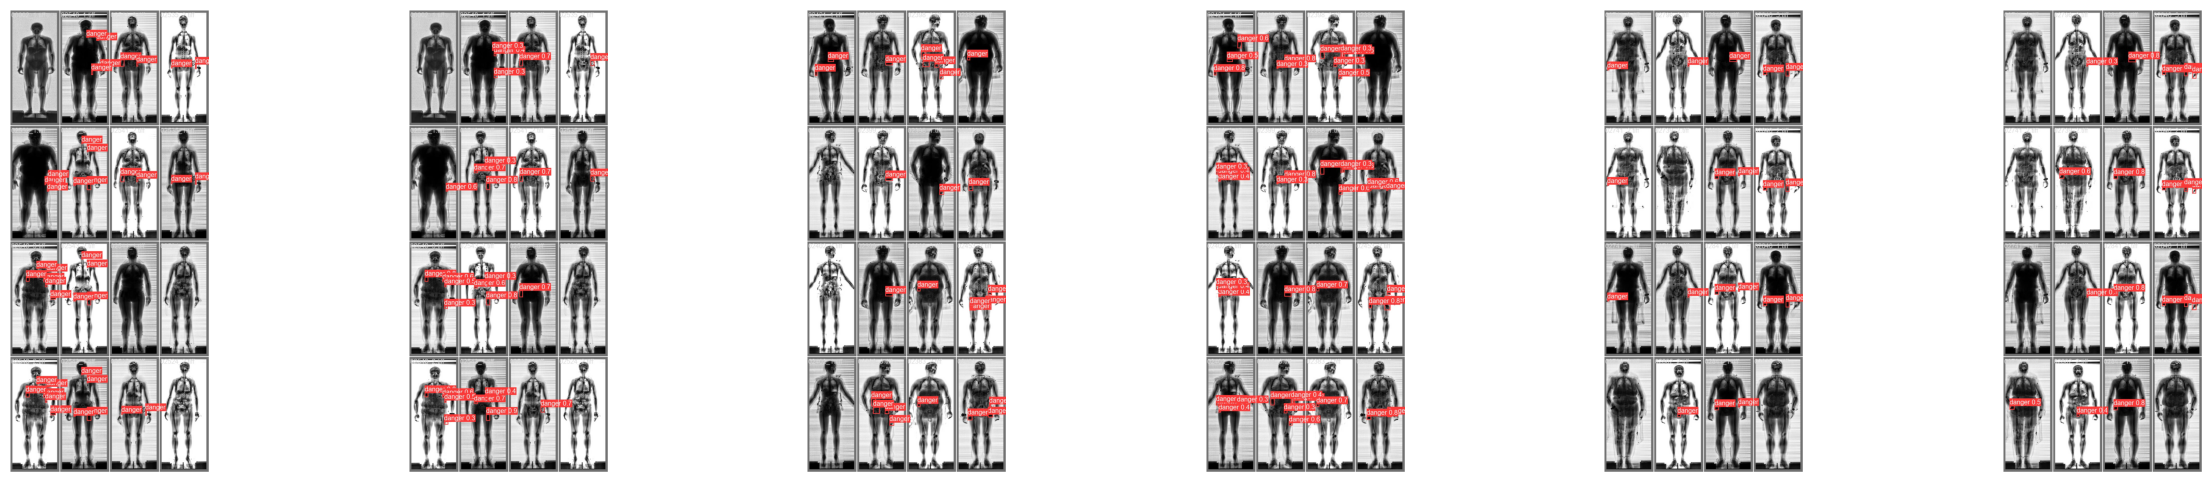

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#  6 изображений
image_paths = ['/content/sample_data/runs_best /val_batch0_labels.jpg','/content/sample_data/runs_best /val_batch0_pred.jpg','/content/sample_data/runs_best /val_batch1_labels.jpg','/content/sample_data/runs_best /val_batch1_pred.jpg','/content/sample_data/runs_best /val_batch2_labels.jpg','/content/sample_data/runs_best /val_batch2_pred.jpg']
# Создание subplot с одним рядом и двумя колонками
fig, axs = plt.subplots(1, 6, figsize=(30, 6))

# Загрузка и отображение каждого изображения в subplot
for i in range(6):
    if i < len(image_paths):
        img = mpimg.imread(image_paths[i])
        axs[i].imshow(img)
        axs[i].axis('off')

plt.show()

Этот код будет выводить первые пять изображений валидационного датасета, удовлетворяющих условиям в цикле.

In [ ]:
import os

cnt = 0
for pred in preds:
    if cnt >= 5:  # Изменяем условие на показ первых пяти изображений
        break
    if not pred.path.endswith('3.tiff'):
        continue
    if len(pred.boxes.data) < 2:
        continue

    # Предсказание на валидационном датасете
    prediction = model.predict('/content/dataset/val/images')

    img = Image.open(os.path.join(pred.save_dir, pred.path.split('/')[-1]))
    display(img)
    cnt += 1


In [ ]:
preds = model.predict('/content/dataset/test/images', name='val_predict', save=True)

In [ ]:
 from PIL import Image
import os

cnt = 0
for pred in preds:
    if cnt > 10:
        break
    if not pred.path.endswith('3.tiff'):
        continue
    if len(pred.boxes.data) < 2:
        continue

    # Предсказание на валидационном датасете
    prediction = model.predict('/content/dataset/test/images')

    img = Image.open(os.path.join(pred.save_dir, pred.path.split('/')[-1]))
    display(img)
    cnt += 1

In [ ]:
preds = model.predict('/content/dataset/val/images', name='val_predict', save=True)